In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

In [4]:
training_dataset = torchvision.datasets.MNIST(root='./mnist_folder', 
                                           train=True, 
                                           transform= transforms.ToTensor(), 
                                           download=True)

testing_dataset = torchvision.datasets.MNIST(root='./mnist_folder', 
                                          train=False, 
                                          transform= transforms.ToTensor(), 
                                          download=False)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset= training_dataset,
                                           batch_size= batch_size,
                                           shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset= testing_dataset,
                                           batch_size= batch_size,
                                           shuffle= False)

In [6]:
## fully connected NN with one hidden layer

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

            ## RNN or GRU 
            ### -> x needs to be: (batch_size, seq, input_size)
        # self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)


            ## LSTM
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)


        self.fc = nn.Linear(hidden_size, num_classes)       ## fully connected layer

    def forward(self, x):
        ## RNN and GRU
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        ## x: (n, 28, 28)        ## n = input batch size      (28, 28) = image size  ( 28 input size .. 28 sequence length)
        ## h0: (2, n, 128)       ## 2 = number_of_layer (first layer output will be the input to second layer)
                                  # n = batch size    128 = hidden size
        ## Forward propagate RNN
        # out, _ = self.rnn(x, h0)
            ## or
        out, _ = self.gru(x, h0)


            ### Set initial hidden states (and cell states for LSTM)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # out, _ = self.lstm(x, (h0,c0))

        ## out: tensor of shape (batch_size, seq_length, hidden_size)
        ## out: (n, 28, 128)

            ## Decode the hidden state of the last time step
        out = out[:, -1, :]         ## all batch ,  last timestep , all hidden size  .... it will make one dimension less tensor
                                    ## now the output size is => all batch , all hidden size
            ## out: (n, 128)
        out = self.fc(out)
            ## out: (n, 10)
        return out

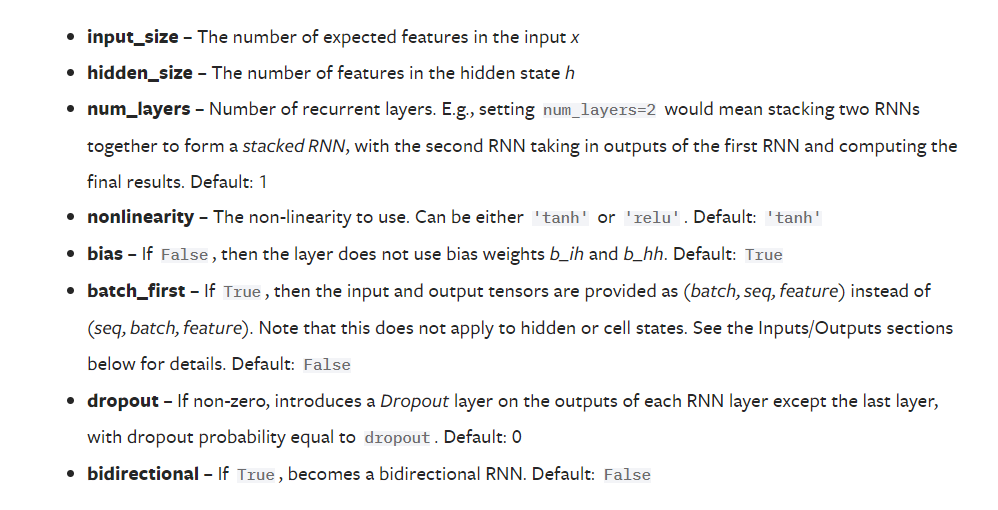

In [7]:
        ### example of tensor slicing
x = torch.rand(3, 3, 4)
print(x.size())
print(x[0])
print(x[1])
print(x[2])
y = x[:, -1, :]      ## this will do slicing of the array .. it will take only last row of each tensor and combine all of them 
                     ## together and made a new tensor
print(y.size())
print(y)

torch.Size([3, 3, 4])
tensor([[0.7131, 0.7573, 0.9566, 0.7943],
        [0.6916, 0.8079, 0.1501, 0.8193],
        [0.1169, 0.8537, 0.3803, 0.3377]])
tensor([[0.4151, 0.2239, 0.2622, 0.5683],
        [0.9789, 0.9219, 0.3307, 0.2343],
        [0.4577, 0.0866, 0.0140, 0.7686]])
tensor([[0.1832, 0.2094, 0.6399, 0.6947],
        [0.6774, 0.7043, 0.5454, 0.7050],
        [0.3405, 0.3395, 0.4232, 0.9892]])
torch.Size([3, 4])
tensor([[0.1169, 0.8537, 0.3803, 0.3377],
        [0.4577, 0.0866, 0.0140, 0.7686],
        [0.3405, 0.3395, 0.4232, 0.9892]])


In [8]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
### Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        ## origin shape: [N, 1, 28, 28]      N = batch size 
        ## resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)     ## here the reshape will reduse one dimension
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/2], Step [100/600], Loss: 0.8168
Epoch [1/2], Step [200/600], Loss: 0.4416
Epoch [1/2], Step [300/600], Loss: 0.2511
Epoch [1/2], Step [400/600], Loss: 0.1319
Epoch [1/2], Step [500/600], Loss: 0.1524
Epoch [1/2], Step [600/600], Loss: 0.1346
Epoch [2/2], Step [100/600], Loss: 0.1695
Epoch [2/2], Step [200/600], Loss: 0.1279
Epoch [2/2], Step [300/600], Loss: 0.0960
Epoch [2/2], Step [400/600], Loss: 0.0525
Epoch [2/2], Step [500/600], Loss: 0.0618
Epoch [2/2], Step [600/600], Loss: 0.0513


In [10]:
## Test the model
## In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.96 %
